In [1]:
import tushare as ts
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aip import AipNlp
import seaborn as sns
import copy
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth',100)

In [2]:
ts.set_token('1dad4f86f90aa240de1a30832a5e1ff4e13c646685852f4f7ac30832')
client = AipNlp('18642920', 'oO37WyBG5Gr40awgBFDqfoLm', 'rHRwzgkf1fW0YnuMVY8KXlqUpNU5s38W')
pro=ts.pro_api()
start_date='20180901'
end_date='20180930'
discribe=pd.read_csv('desc.csv')

In [3]:
stock_index=ts.get_hs300s()['code'].values.tolist()
stock_index=list(map(lambda x: x+'.SH' if x[0]=='6' else x+'.SZ', stock_index))

## preprocesssion: dropna, clean some biz item

In [4]:
##whether need to remove the negative value?
biz_item=pd.read_csv('biz_item.csv').drop(columns=['bz_profit','bz_cost','curr_type','Unnamed: 0'])
##there are 76 na in bz_sales column. Most of them are 其他业务
biz_item.dropna(inplace=True)
biz_item['end_date']=pd.to_datetime(biz_item['end_date'],format='%Y%m%d')
biz_item['bz_item']=biz_item['bz_item'].str.replace('其他|产品|业务|收入|提供|系列','')
sign=['\,','\.','，','。','\(','\)','（','）',':','：',';','；','、','【','】']
sign='|'.join(sign)
biz_item['bz_item']=biz_item['bz_item'].str.replace(sign,'')
biz_item=biz_item[biz_item['bz_item']!='']
biz_item['index']= np.arange(biz_item.shape[0])##don't use pd.Series. some wired na be generated
stock_index=list(set(biz_item['ts_code']))

### generate weight

In [5]:
sum_sales=biz_item.groupby(by=['ts_code','end_date'],as_index=False)['bz_sales'].sum()
sum_sales.rename(columns={'bz_sales':'sum_sales'},inplace=True)
biz_item=pd.merge(biz_item,sum_sales,on=['ts_code','end_date'])
biz_item['weights']=biz_item['bz_sales']/biz_item['sum_sales']
biz_item.drop(columns=['sum_sales'],inplace=True)

### select the most recently report for every company

In [6]:
all_biz_item=biz_item.groupby(by=['ts_code'])
recent_biz_item={key: value[value['end_date']==value['end_date'].max()] for key, value in all_biz_item}
recent_biz_item=pd.concat(recent_biz_item.values())

In [7]:
print('There are %d company after processing'%len(stock_index))
print('There are %d observation after processing'%recent_biz_item.shape[0])
recent_biz_item.head()

There are 299 company after processing
There are 1724 observation after processing


,ts_code,end_date,bz_item,bz_sales,index,weights
14556,000001.SZ,2019-12-31,利息发放贷款及垫款个人贷款,9.527400e+10,14556,0.427008
14557,000001.SZ,2019-12-31,利息金融投资利息,3.091300e+10,14557,0.138549
14558,000001.SZ,2019-12-31,非利息手续费及佣金财务顾问,1.245000e+09,14558,0.005580
14559,000001.SZ,2019-12-31,非利息手续费及佣金结算,2.789000e+09,14559,0.012500
14560,000001.SZ,2019-12-31,利息金融企业往来,9.681000e+09,14560,0.043389


## Get embadding matrix from bert

In [8]:
#this is the code to get embadding matrix from bert
from bert_serving.client import BertClient
bc = BertClient()
word=recent_biz_item['bz_item'].values.tolist()
embadding=bc.encode(word)
#pd.DataFrame(embadding).to_csv('embadding_i.csv')

In [9]:
embadding=pd.read_csv('embadding_i.csv').values
print('Embadding matrix shape is: ',embadding.shape)

Embadding matrix shape is:  (1724, 769)


## Compare bert with baidu

In [13]:
compare=pd.DataFrame(columns=['word1','word2','baidu score','bert score'],index=np.arange(0,1000))
rand=np.random.randint(1,1700,size=(1000,2))
item_list=biz_item['bz_item'].values.tolist()
for i in range(1000):
    word1=item_list[rand[i,0]]
    word2=item_list[rand[i,1]]
    baidu=client.simnet(word1, word2)['score']
    bert=np.corrcoef(bc.encode([word1, word2]))[0,1]
    compare.iloc[i,:]=[word1,word2,baidu,bert]

In [15]:
compare.head()

,word1,word2,baidu score,bert score
0,航空,融资融券,0.443129,0.728731
1,路面机械,电路及网元租赁,0.356094,0.855484
2,宽带及移动数据服务,非利息手续费及佣金,0.384797,0.81455
3,水力发电,主营,0.396241,0.703259
4,电力及热力,利息债券投资,0.36481,0.769355


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.906
Model:                            OLS   Adj. R-squared (uncentered):              0.906
Method:                 Least Squares   F-statistic:                              9628.
Date:                Mon, 09 Mar 2020   Prob (F-statistic):                        0.00
Time:                        02:03:12   Log-Likelihood:                         -4.5970
No. Observations:                1000   AIC:                                      11.19
Df Residuals:                     999   BIC:                                      16.10
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

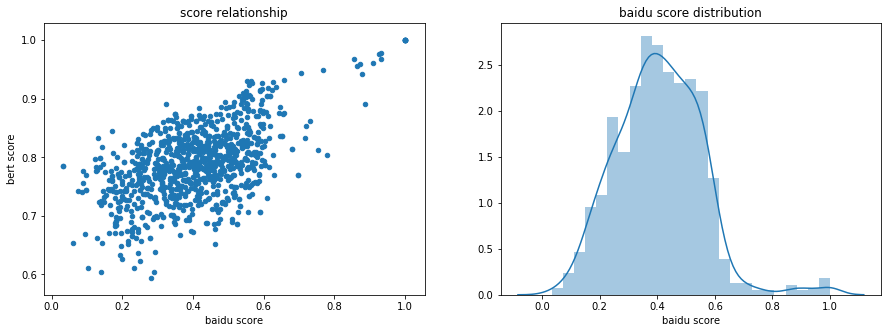

In [16]:
import statsmodels.api as sm
fig, ax= plt.subplots(1,2,figsize=(15,5))
compare.plot.scatter(x='baidu score',y='bert score',title='score relationship',ax=ax[0])
sns.distplot(compare['baidu score'],ax=ax[1])
ax[1].set_title('baidu score distribution')
mod=sm.OLS(compare['bert score'].values.tolist(),compare['baidu score'].values.tolist()).fit()
print(mod.summary())

## Calculate the correlation

In [9]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
embadding=scaler.fit_transform(embadding.T).T
combind_biz_item=pd.concat([recent_biz_item,pd.DataFrame(embadding,index=recent_biz_item.index)],axis=1)
combind_biz_item.iloc[:,5:]=combind_biz_item.iloc[:,5:].mul(combind_biz_item['weights'].values.tolist(),axis=0)
combind_biz_item.head()

,ts_code,end_date,bz_item,bz_sales,index,weights,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
14556,000001.SZ,2019-12-31,利息发放贷款及垫款个人贷款,9.527400e+10,14556,0.182336,0.312851,0.137647,-0.184629,-0.121173,0.246334,-0.326446,-0.305990,-0.131198,0.266190,-0.047858,0.225561,-0.075445,0.156192,0.157984,1.050180,-0.015252,-0.216953,0.150510,0.302694,0.354662,0.123531,0.085546,0.243058,0.387726,0.138405,-0.124403,0.235918,-0.236381,0.009261,0.168903,-0.181476,0.025611,-0.022574,0.100492,-0.060032,0.107389,-0.180055,0.240748,0.009843,0.095103,-0.204441,-0.218896,-0.088163,0.272260,-0.317673,0.119466,-0.187253,-0.386070,0.117903,-0.031794,-0.053633,5.871854,0.064495,0.000636,-0.321584,0.245264,0.287456,0.213561,-0.036938,0.418867,-0.028746,0.426218,-0.288447,0.473775,-0.230338,-0.197966,0.038137,0.074851,-0.027782,-0.050791,-0.153935,-0.027451,-0.330314,-0.042481,0.171390,0.017637,0.266041,-0.478294,-0.235241,-0.098731,-0.211789,-0.325962,-0.359689,-0.186748,-0.091444,-0.514409,0.056114,0.059313,-0.029298,-0.064100,-0.175821,-0.249302,-0.444856,0.047339,-0.193815,0.615763,0.2170

In [10]:
company_map={}
for i in stock_index:
    company_map[i]={}
    i_company=combind_biz_item[combind_biz_item['ts_code']==i].iloc[:,5:].values
    n_i=i_company.shape[0]
    for j in stock_index:
        j_company=combind_biz_item[combind_biz_item['ts_code']==j].iloc[:,5:].values
        n_j=j_company.shape[0]
        temp_matrix=np.concatenate((i_company,j_company),axis=0)
        cor_matrix=np.cov(temp_matrix)[n_i:,:n_i]
        company_map[i][j]=cor_matrix.sum()

In [ ]:
company_map_baidu={}
for i in stock_index:
    company_map_baidu[i]={}
    i_company=combind_biz_item[combind_biz_item['ts_code']==i].iloc[:,5:].values
    n_i=i_company.shape[0]
    for j in stock_index:
        j_company=combind_biz_item[combind_biz_item['ts_code']==j].iloc[:,5:].values
        n_j=j_company.shape[0]
        temp_matrix=np.concatenate((i_company,j_company),axis=0)
        cor_matrix=np.cov(temp_matrix)[n_i:,:n_i]
        company_map[i][j]=cor_matrix.sum()

## See correlationship distribution from bert

In [11]:
all_relation=[]
for key,items in company_map.items():
    for subkey,subitems in items.items():
        all_relation.append(subitems)

The maximum of bert corr is  1.2249030974878556
The minimum of bert corr is  0.5851212687561527


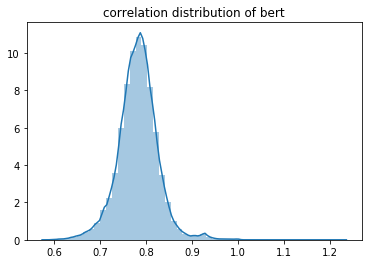

In [12]:
sns.distplot(all_relation)
plt.title('correlation distribution of bert')
print('The maximum of bert corr is ',max(all_relation))
print('The minimum of bert corr is ',min(all_relation))

## change bert distribution to 0-1

Text(0.5, 1.0, 'correlation distribution of baidu')

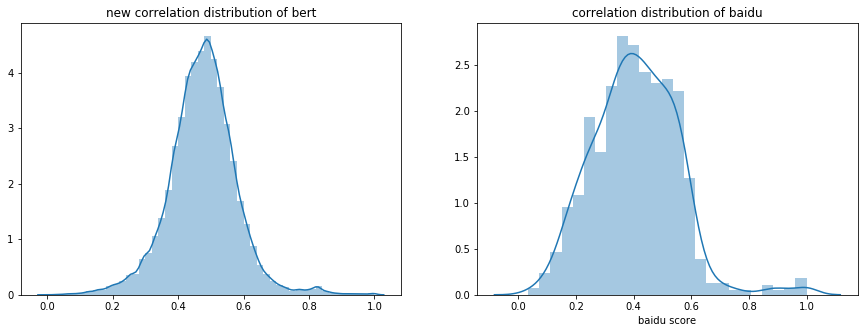

In [26]:
transferd_company_map=copy.deepcopy(company_map)
all_transferd_relation=[]
base=min(all_relation)
scale=1-base
for key, item in transferd_company_map.items():
    for subkey,subitem in item.items():
        transferd_company_map[key][subkey]=(subitem-base)/scale if transferd_company_map[key][subkey]<1 else 1
        all_transferd_relation.append(transferd_company_map[key][subkey])
fig, ax= plt.subplots(1,2,figsize=(15,5))
sns.distplot(all_transferd_relation,ax=ax[0])
ax[0].set_title('new correlation distribution of bert')

sns.distplot(compare['baidu score'],ax=ax[1])
ax[1].set_title('correlation distribution of baidu')

In [14]:
f=open('company dic i.txt','w')
f.write(str(company_map))
f.close()

In [16]:
f=open('company dic i.txt','r')
dic=f.read()
company_map_i=eval(dic)
f.close

<function TextIOWrapper.close()>